In [204]:
%reload_ext autoreload
%autoreload 2

In [219]:
import ast
import gensim
import numpy as np
import pandas as pd

from pathlib import Path
from nltk import word_tokenize
from gensim.models import Word2Vec
from category_encoders import WOEEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, validation_curve, KFold

from nlp_dauphine.preprocess_texts import (
    load_data,
    categorical_other,
)
from nlp_dauphine.embeddings import (
    vocabulary,
    print_neighbors,
    sentence_representations,
    co_occurence_matrix,
)
from nlp_dauphine.preprocess_time_series import compute_rolling, compute_metrics
from nlp_dauphine.utils import set_working_dir, cosine, euclidean
from nlp_dauphine.eval import plot_importance_rf, model_eval, concat_data_flow


In [3]:
set_working_dir()

Current working dir: c:/Users/Hugo/Documents/Travail/A5/Dauphine_challenge/nlp_dauphine/notebooks
New working dir: c:/Users/Hugo/Documents/Travail/A5/Dauphine_challenge/nlp_dauphine


# Load Data

In [4]:
path = Path("data")
files_path = {
    "ecb": Path(path,"ecb_data_translate_cleaned.csv"),
    "fed": Path(path,"fed_data_translate_cleaned.csv"),
    "train_series": Path(path,"train_series_clean_no_0.csv"),
}

In [5]:
# LOAD TEXT DATA
df_ecb, df_fed, df_train_series = load_data(files_path)
print(df_ecb.shape, df_fed.shape, df_train_series.shape)

(1772, 6) (739, 6) (8240, 20)


In [6]:
df_train_series.list_speakers_ecb = df_train_series.list_speakers_ecb.apply(ast.literal_eval)
df_train_series.list_speakers_fed = df_train_series.list_speakers_fed.apply(ast.literal_eval)
df_train_series.id_ecb = df_train_series.id_ecb.apply(ast.literal_eval)
df_train_series.id_fed = df_train_series.id_fed.apply(ast.literal_eval)
df_train_series.list_languages_ecb = df_train_series.list_languages_ecb.apply(ast.literal_eval)

# Data Modelisation

## Train Test Split

In [7]:
# Train test split 
X=df_train_series.loc[:,df_train_series.columns!="Index + 1"]
y=np.sign(df_train_series[["Index + 1"]])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42)
print(X_train.shape,y_train.shape)

(6592, 19) (6592, 1)


# Categorical Encoding 

For the speakers WOEEncoder rather than One-hot encoding

In [8]:
col_speakers = ["speaker_"+str(i+1) for i in range(4)]

X_train = pd.concat([X_train, X_train['list_speakers_ecb'].apply(pd.Series)], axis=1)
X_train.rename({i:col for i, col in enumerate(col_speakers)},axis=1,inplace=True)

X_test = pd.concat([X_test, X_test['list_speakers_ecb'].apply(pd.Series)], axis=1)
X_test.rename({i:col for i, col in enumerate(col_speakers)},axis=1,inplace=True)

enc = WOEEncoder(cols=col_speakers)
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)

X_train.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)

c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_

for the index and the languages, one hot encoding 

In [9]:
X_train = pd.get_dummies(X_train, prefix ="",columns=["Index Name"], drop_first=False)
X_test = pd.get_dummies(X_test, prefix ="",columns=["Index Name"], drop_first=False)

In [10]:
df_lang_train = (
    pd.get_dummies(X_train.list_languages_ecb.apply(pd.Series).stack(), prefix="ecb")
    .groupby(level=0)
    .sum()
)
X_train = pd.concat([X_train, df_lang_train], axis=1)
df_lang_test = (
    pd.get_dummies(X_test.list_languages_ecb.apply(pd.Series).stack(), prefix="ecb")
    .groupby(level=0)
    .sum()
)
X_test = pd.concat([X_test, df_lang_test], axis=1)


In [11]:
cols_to_drop = [
    "id_ecb",
    "id_fed",
    "id_series",
    "list_speakers_fed",
    "list_speakers_ecb",
    "list_languages_ecb",
]
X_test.drop(cols_to_drop, axis=1, inplace=True)
X_train.drop(cols_to_drop, axis=1, inplace=True)


In [12]:
X_test.columns

Index(['Index - 9', 'Index - 8', 'Index - 7', 'Index - 6', 'Index - 5',
       'Index - 4', 'Index - 3', 'Index - 2', 'Index - 1', 'Index - 0',
       'text_concat_ecb', 'text_concat_fed', 'speaker_1', 'speaker_2',
       'speaker_3', 'speaker_4', '_CVIX Index', '_EURUSD Curncy',
       '_EURUSDV1M Curncy', '_MOVE Index', '_SPX Index', '_SRVIX Index',
       '_SX5E Index', '_V2X Index', '_VIX Index', 'ecb_de', 'ecb_en', 'ecb_es',
       'ecb_fr', 'ecb_it'],
      dtype='object')

# Text Embeddings

## Word Embeddings


### 1st Method: Vocabulary -> Co-Occurence Matrix -> SVD 

#### Vocabulary 

In [13]:
word2id_7500,word_counts_7500 = vocabulary(X_train.text_concat_ecb,7500)

#### Co-occurence Matrix

In [14]:
M5dist_ecb = co_occurence_matrix(X_train.text_concat_ecb, word2id_7500, window=5, distance_weighting=True)
M5dist_fed = co_occurence_matrix(X_train.text_concat_fed, word2id_7500, window=5, distance_weighting=True)

co-occurence matrix: 100%|██████████| 6592/6592 [03:00<00:00, 36.51it/s]


#### Scaling

In [15]:
scaler = StandardScaler()
M5dist_ecb = scaler.fit_transform(M5dist_ecb)
M5dist_fed = scaler.fit_transform(M5dist_fed)

#### SVD

In [16]:
svd = TruncatedSVD(n_components=200)
SVDEmbeddings_ecb = svd.fit_transform(M5dist_ecb)
SVDEmbeddings_fed = svd.fit_transform(M5dist_fed)
print(SVDEmbeddings_ecb.shape, SVDEmbeddings_fed.shape)

(7501, 200) (7501, 200)


In [17]:
svd.explained_variance_ratio_.sum()

0.6075709759986083

#### Analysis

In [107]:
print_neighbors(cosine, word2id_7500, SVDEmbeddings_ecb, 'financial')
print_neighbors(cosine, word2id_7500, SVDEmbeddings_fed, 'financial')

Plus proches voisins de financial selon la distance 'cosine': 
[['turmoil', 'instability', 'turbulence', 'contagion', 'market', 'vulnerability', 'assess', 'various', 'crisis']]
Plus proches voisins de financial selon la distance 'cosine': 
[['pose', 'crisis', 'function', 'system', 'strengthen', 'severe', 'intermediary', 'market', 'UNK']]


In [108]:
print_neighbors(euclidean, word2id_7500, SVDEmbeddings_ecb, 'financial')
print_neighbors(euclidean, word2id_7500, SVDEmbeddings_fed, 'financial')

Plus proches voisins de financial selon la distance 'euclidean': 
[['system', 'stability', 'crisis', 'sector', 'global', 'institution', 'also', 'market', 'economy']]
Plus proches voisins de financial selon la distance 'euclidean': 
[['crisis', 'system', 'stability', 'institution', 'firm', 'large', 'condition', 'global', 'risk']]


### 2nd Method: Vocabulary -> W2Vec

In [18]:
word2id_7500, word_counts_7500 = vocabulary(X_train.text_concat_ecb,7500)

In [19]:
w2vec_fed = Word2Vec(vector_size=100,
                 window=5,
                 null_word=len(word_counts_7500))
w2vec_fed.build_vocab_from_freq(word_counts_7500)
w2vec_ecb = Word2Vec(vector_size=100,
                 window=5,
                 null_word=len(word_counts_7500))
w2vec_ecb.build_vocab_from_freq(word_counts_7500)

In [20]:
preprocessed_corpus_ecb = [
    word_tokenize(X_train.text_concat_ecb.values[i])
    for i in range(len(X_train.text_concat_ecb))
]

preprocessed_corpus_fed = [
    word_tokenize(X_train.text_concat_fed.values[i])
    for i in range(len(X_train.text_concat_fed))
]

In [21]:
w2vec_ecb.train(
    preprocessed_corpus_ecb,
    total_examples=len(X_train.text_concat_ecb),
    epochs=20,
    report_delay=1,
)


(213234031, 235516700)

In [22]:
w2vec_fed.train(
    preprocessed_corpus_fed,
    total_examples=len(X_train.text_concat_fed),
    epochs=20,
    report_delay=1,
)


(244000201, 271917220)

In [23]:
W2VEmbeddings_ecb = w2vec_ecb.wv.vectors
W2VEmbeddings_ecb.shape

(7501, 100)

In [24]:
W2VEmbeddings_fed = w2vec_fed.wv.vectors
W2VEmbeddings_fed.shape

(7501, 100)

### 3rd method: Pretrained Embedding on Finance Corpora

In [25]:
model_gn = gensim.models.KeyedVectors.load_word2vec_format('data/bankfinvec_100d_v1.txt')
model_gn = gensim.models.KeyedVectors.load_word2vec_format('data/custom_finvec_100d.txt')

In [26]:
vocab_size = 7501
emb_size = 100
embeddings_bankfin = np.zeros(shape=(vocab_size, emb_size))
words = []
count=0
for word, idx in word2id_7500.items():
    if word in model_gn.key_to_index:
        embeddings_bankfin[idx, :] = model_gn[word]
    else:
        count+=1
        words.append(word)
        embeddings_bankfin[idx, :] = np.zeros(emb_size)
count

3677

I'm pretty sure it is going to be super bad because half of the words are not in this dictionary

In [27]:
embeddings_bankfin.shape

(7501, 100)

## Document Representation

AVERAGING MODEL

In [28]:
txt_ecb = X_train.text_concat_ecb
txt_fed = X_train.text_concat_fed
txt_ecb_val = X_test.text_concat_ecb
txt_fed_val = X_test.text_concat_fed

In [29]:
train_rep_ecb_svd = sentence_representations(txt_ecb, word2id_7500, SVDEmbeddings_ecb, np_func=np.mean)
train_rep_fed_svd = sentence_representations(txt_fed, word2id_7500, SVDEmbeddings_fed, np_func=np.mean)
val_rep_ecb_svd = sentence_representations(txt_ecb_val, word2id_7500, SVDEmbeddings_ecb, np_func=np.mean)
val_rep_fed_svd = sentence_representations(txt_fed_val, word2id_7500, SVDEmbeddings_fed, np_func=np.mean)

100%|██████████| 1648/1648 [00:09<00:00, 171.55it/s]


In [30]:
train_rep_ecb_w2v = sentence_representations(txt_ecb, word2id_7500, W2VEmbeddings_ecb, np_func=np.mean)
train_rep_fed_w2v = sentence_representations(txt_fed, word2id_7500, W2VEmbeddings_fed, np_func=np.mean)
val_rep_ecb_w2v = sentence_representations(txt_ecb_val, word2id_7500, W2VEmbeddings_ecb, np_func=np.mean)
val_rep_fed_w2v = sentence_representations(txt_fed_val, word2id_7500, W2VEmbeddings_fed, np_func=np.mean)

100%|██████████| 1648/1648 [00:07<00:00, 214.53it/s]


In [31]:
train_rep_ecb_fin = sentence_representations(txt_ecb, word2id_7500, embeddings_bankfin, np_func=np.mean)
train_rep_fed_fin = sentence_representations(txt_fed, word2id_7500, embeddings_bankfin, np_func=np.mean)
val_rep_ecb_fin = sentence_representations(txt_ecb_val, word2id_7500, embeddings_bankfin, np_func=np.mean)
val_rep_fed_fin = sentence_representations(txt_fed_val, word2id_7500, embeddings_bankfin, np_func=np.mean)

100%|██████████| 1648/1648 [00:08<00:00, 200.76it/s]


# Time Series Feature Engineering 

In [158]:
operations = ["std", "mean", "quantile_2", "quantile_8", "sum","ewm","pct_change"]
nb_quantiles = [0.8, 0.2]
time_windows = [2, 5, 7]
params = []
for op in operations:
    for tw in time_windows:
        if "quantile" in op:
            for q in nb_quantiles:
                params.append(
                    {
                        "operation": op,
                        "time_window": tw,
                        "nb_quantile": q,
                    }
                )
        else:
            params.append(
                {
                    "operation": op,
                    "time_window": tw,
                }
            )

In [159]:
X_train_series = X_train.iloc[:,:10]
X_train_series = compute_rolling(X_train_series, params)

In [160]:
X_test_series = X_test.iloc[:,:10]
X_test_series = compute_rolling(X_test_series, params)

In [161]:
X_train_global_ft = compute_metrics(X_train.iloc[:,:10])[["skew","kurt"]]
X_test_global_ft = compute_metrics(X_test.iloc[:,:10])[["skew","kurt"]]

# Full Model 

## Concat Data

In [168]:
X_train_concat = concat_data_flow(
    X_train.iloc[:, 12:],
    X_train_series,
    X_train_global_ft,
    train_rep_ecb_svd,
    train_rep_fed_svd,
)


X_test_concat = concat_data_flow(
    X_test.iloc[:, 12:],
    X_test_series,
    X_test_global_ft,
    val_rep_ecb_svd,
    val_rep_fed_svd,
)

X_train_concat.shape, X_test_concat.shape

((6592, 451), (1648, 451))

In [169]:
X_train_concat2 = concat_data_flow(
    X_train.iloc[:, 12:],
    X_train_series,
    X_train_global_ft,
    train_rep_ecb_w2v,
    train_rep_fed_w2v,
)


X_test_concat2 = concat_data_flow(
    X_test.iloc[:, 12:],
    X_test_series,
    X_test_global_ft,
    val_rep_ecb_w2v,
    val_rep_fed_w2v,
)

X_train_concat2.shape, X_test_concat2.shape

((6592, 251), (1648, 251))

In [170]:
X_train_concat3 = concat_data_flow(
    X_train.iloc[:, 12:],
    X_train_series,
    X_train_global_ft,
    train_rep_ecb_fin,
    train_rep_fed_fin,
)


X_test_concat3 = concat_data_flow(
    X_test.iloc[:, 12:],
    X_test_series,
    X_test_global_ft,
    val_rep_ecb_fin,
    val_rep_fed_fin,
)

X_train_concat3.shape, X_test_concat3.shape

((6592, 251), (1648, 251))

## Logistic Regression

1st Method (SVD)

Score of the LogReg_SVD pipeline: 0.6130157766990292 (train set)
Score of the LogReg_SVD pipeline: 0.533373786407767 (test set)
Overfitting estimated at : 0.07964199029126218
              precision    recall  f1-score   support

        -1.0       0.53      0.58      0.55       822
         1.0       0.54      0.49      0.51       826

    accuracy                           0.53      1648
   macro avg       0.53      0.53      0.53      1648
weighted avg       0.53      0.53      0.53      1648



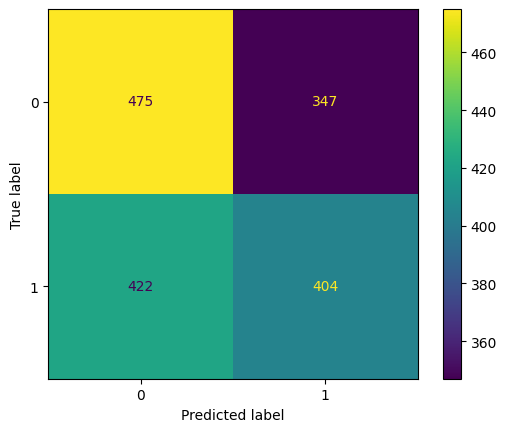

In [82]:
clf = LogisticRegression(random_state=42,max_iter=20_000)
clf = model_eval(
    clf,
    "LogReg_SVD",
    X_train_concat,
    np.array(y_train).ravel(),
    X_test_concat,
    np.array(y_test).ravel(),
)

2nd Method

Score of the LogReg_Word2Vec pipeline: 0.5837378640776699 (train set)
Score of the LogReg_Word2Vec pipeline: 0.5224514563106796 (test set)
Overfitting estimated at : 0.06128640776699035
              precision    recall  f1-score   support

        -1.0       0.52      0.57      0.54       822
         1.0       0.53      0.48      0.50       826

    accuracy                           0.52      1648
   macro avg       0.52      0.52      0.52      1648
weighted avg       0.52      0.52      0.52      1648



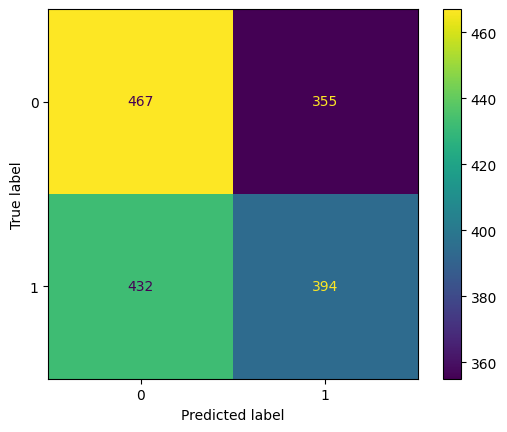

In [83]:
clf2 = LogisticRegression(random_state=42,max_iter=20_000)
clf2 = model_eval(
    clf2,
    "LogReg_Word2Vec",
    X_train_concat2,
    np.array(y_train).ravel(),
    X_test_concat2,
    np.array(y_test).ravel(),
)

3rd Method

Score of the LogReg_BankFin pipeline: 0.5796419902912622 (train set)
Score of the LogReg_BankFin pipeline: 0.5121359223300971 (test set)
Overfitting estimated at : 0.0675060679611651
              precision    recall  f1-score   support

        -1.0       0.51      0.59      0.54       822
         1.0       0.52      0.44      0.47       826

    accuracy                           0.51      1648
   macro avg       0.51      0.51      0.51      1648
weighted avg       0.51      0.51      0.51      1648



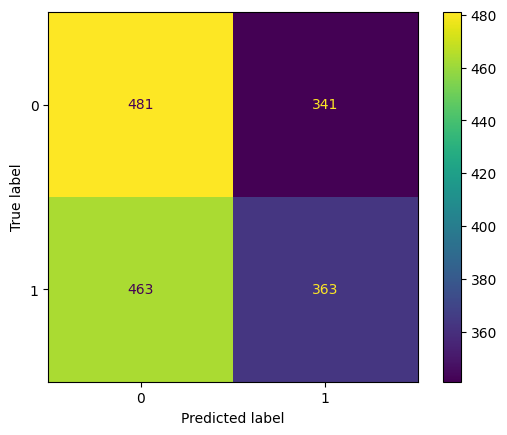

In [84]:
clf3 = LogisticRegression(random_state=42,max_iter=20_000)
clf3 = model_eval(
    clf3,
    "LogReg_BankFin",
    X_train_concat3,
    np.array(y_train).ravel(),
    X_test_concat3,
    np.array(y_test).ravel(),
)

## HistGradientBoosting

Score of the HistGradientBoosting pipeline: 0.9896844660194175 (train set)
Score of the HistGradientBoosting pipeline: 0.5728155339805825 (test set)
Overfitting estimated at : 0.416868932038835
              precision    recall  f1-score   support

        -1.0       0.57      0.59      0.58       822
         1.0       0.58      0.55      0.56       826

    accuracy                           0.57      1648
   macro avg       0.57      0.57      0.57      1648
weighted avg       0.57      0.57      0.57      1648



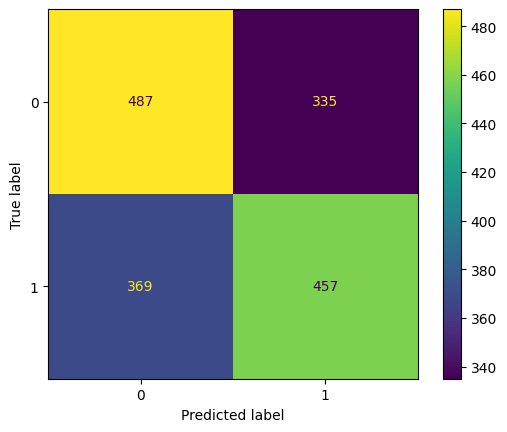

In [78]:
mask_categorical = [
    True if (x <= 17) & (x >= 4) else False for x in range(X_train_concat.shape[1])
]
clf_boost = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=200,
    categorical_features=mask_categorical,
    random_state=42,
)
clf_boost = model_eval(
    clf_boost,
    "HistGradientBoosting_SVD",
    X_train_concat,
    np.array(y_train).ravel(),
    X_test_concat,
    np.array(y_test).ravel(),
)


2nd Method

Score of the HistGradientBoosting_W2Vec pipeline: 0.9908980582524272 (train set)
Score of the HistGradientBoosting_W2Vec pipeline: 0.5788834951456311 (test set)
Overfitting estimated at : 0.4120145631067961
              precision    recall  f1-score   support

        -1.0       0.57      0.60      0.59       822
         1.0       0.58      0.55      0.57       826

    accuracy                           0.58      1648
   macro avg       0.58      0.58      0.58      1648
weighted avg       0.58      0.58      0.58      1648



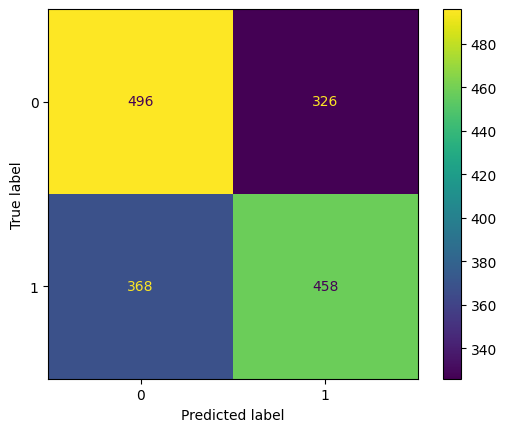

In [79]:
mask_categorical2 = [
    True if (x <=17) & (x>=4) else False for x in range(X_train_concat2.shape[1])
]

clf_boost2 = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=200,
    categorical_features=mask_categorical2,
    random_state=42,
)
clf_boost2 = model_eval(
    clf_boost2,
    "HistGradientBoosting_W2Vec",
    X_train_concat2,
    np.array(y_train).ravel(),
    X_test_concat2,
    np.array(y_test).ravel(),
)


3rd Method

Score of the HistGradientBoosting_BankFin pipeline: 0.9896844660194175 (train set)
Score of the HistGradientBoosting_BankFin pipeline: 0.5904126213592233 (test set)
Overfitting estimated at : 0.39927184466019416
              precision    recall  f1-score   support

        -1.0       0.59      0.61      0.60       822
         1.0       0.59      0.58      0.58       826

    accuracy                           0.59      1648
   macro avg       0.59      0.59      0.59      1648
weighted avg       0.59      0.59      0.59      1648



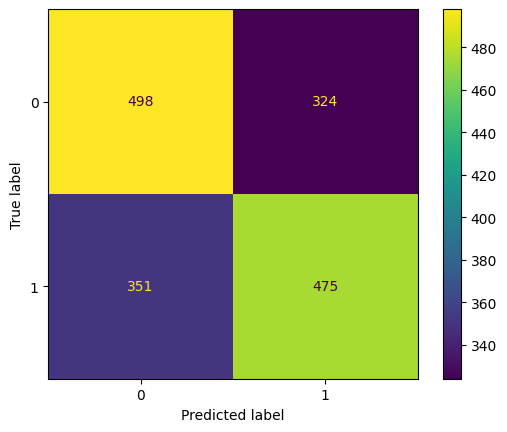

In [81]:
mask_categorical3 = [
    True if (x <=17) & (x>=4) else False for x in range(X_train_concat3.shape[1])
]

clf_boost3 = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=200,
    categorical_features=mask_categorical3,
    random_state=42,
)
clf_boost3 = model_eval(
    clf_boost3,
    "HistGradientBoosting_BankFin",
    X_train_concat3,
    np.array(y_train).ravel(),
    X_test_concat3,
    np.array(y_test).ravel(),
)


## Random Forest

Score of the RandomForest_SVD pipeline: 1.0 (train set)
Score of the RandomForest_SVD pipeline: 0.5703883495145631 (test set)
Overfitting estimated at : 0.4296116504854369
              precision    recall  f1-score   support

        -1.0       0.56      0.60      0.58       822
         1.0       0.58      0.54      0.56       826

    accuracy                           0.57      1648
   macro avg       0.57      0.57      0.57      1648
weighted avg       0.57      0.57      0.57      1648



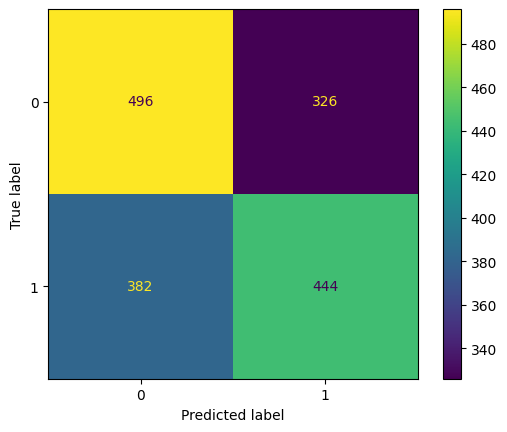

In [207]:
rf = RandomForestClassifier()
rf = model_eval(
    rf,
    "RandomForest_SVD",
    X_train_concat,
    np.array(y_train).ravel(),
    X_test_concat,
    np.array(y_test).ravel(),
)

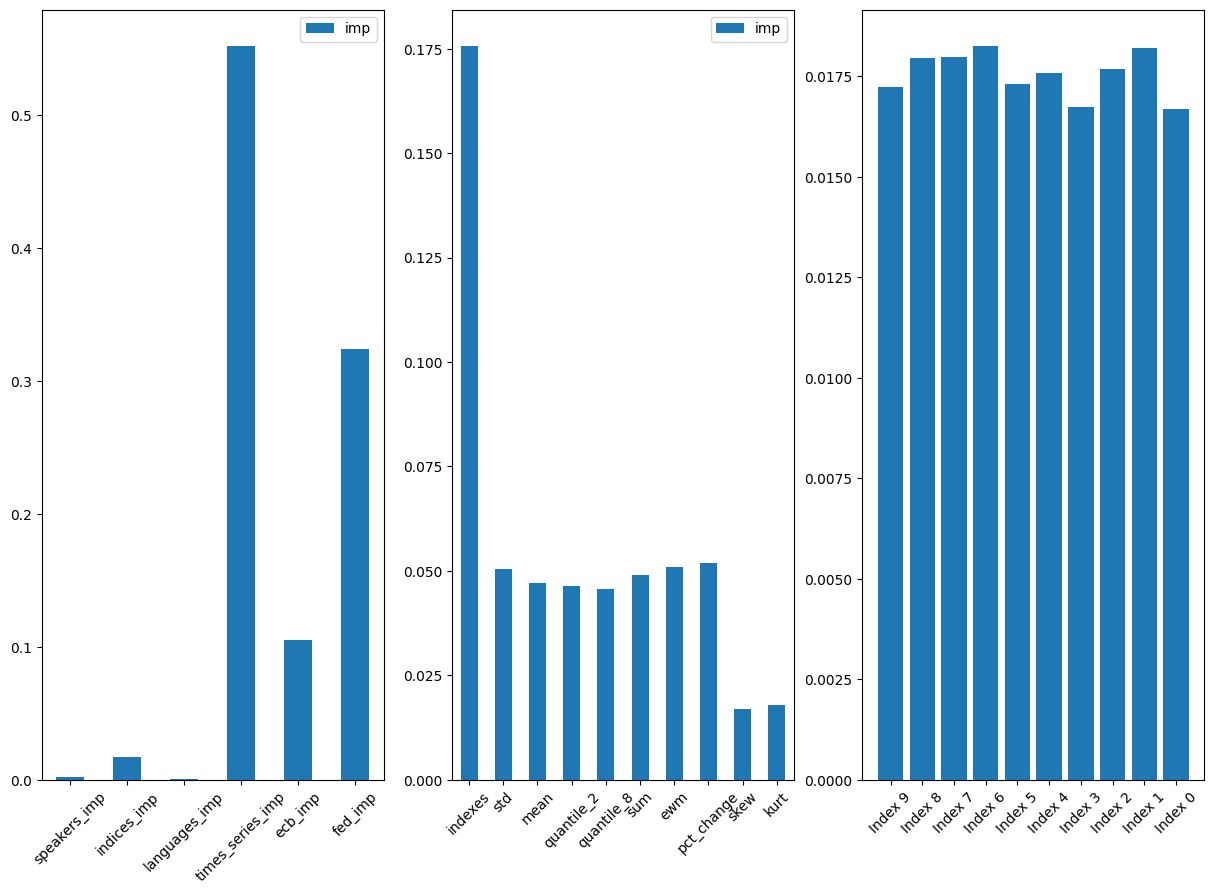

In [226]:
plot_importance_rf(rf.feature_importances_)

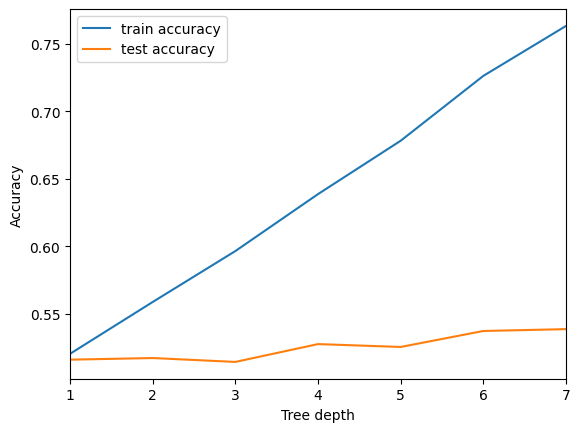

In [77]:
"""cv = KFold(shuffle=True, n_splits=5, random_state=42)
max_depth = [1, 2, 3, 4, 5, 6, 7]
    
train_scores, test_scores = validation_curve(
    rf, X_train_concat, np.array(y_train).ravel(), param_name="max_depth",
    param_range=max_depth, cv=cv,
    scoring="accuracy"
)
plt.plot(max_depth, train_scores.mean(axis=1), label="train accuracy")
plt.plot(max_depth, test_scores.mean(axis=1), label="test accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.xlim([1, max(max_depth)])
plt.legend(loc="best")"""

2nd Method

Score of the RandomForest_W2Vec pipeline: 1.0 (train set)
Score of the RandomForest_W2Vec pipeline: 0.5625 (test set)
Overfitting estimated at : 0.4375
              precision    recall  f1-score   support

        -1.0       0.56      0.60      0.58       822
         1.0       0.57      0.52      0.54       826

    accuracy                           0.56      1648
   macro avg       0.56      0.56      0.56      1648
weighted avg       0.56      0.56      0.56      1648



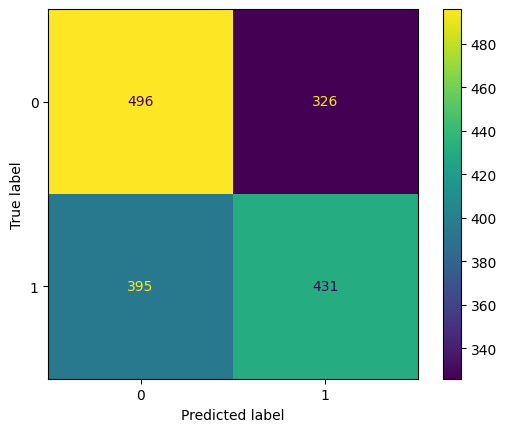

In [173]:
rf2 = RandomForestClassifier()
rf2 = model_eval(
    rf2,
    "RandomForest_W2Vec",
    X_train_concat2,
    np.array(y_train).ravel(),
    X_test_concat2,
    np.array(y_test).ravel(),
)

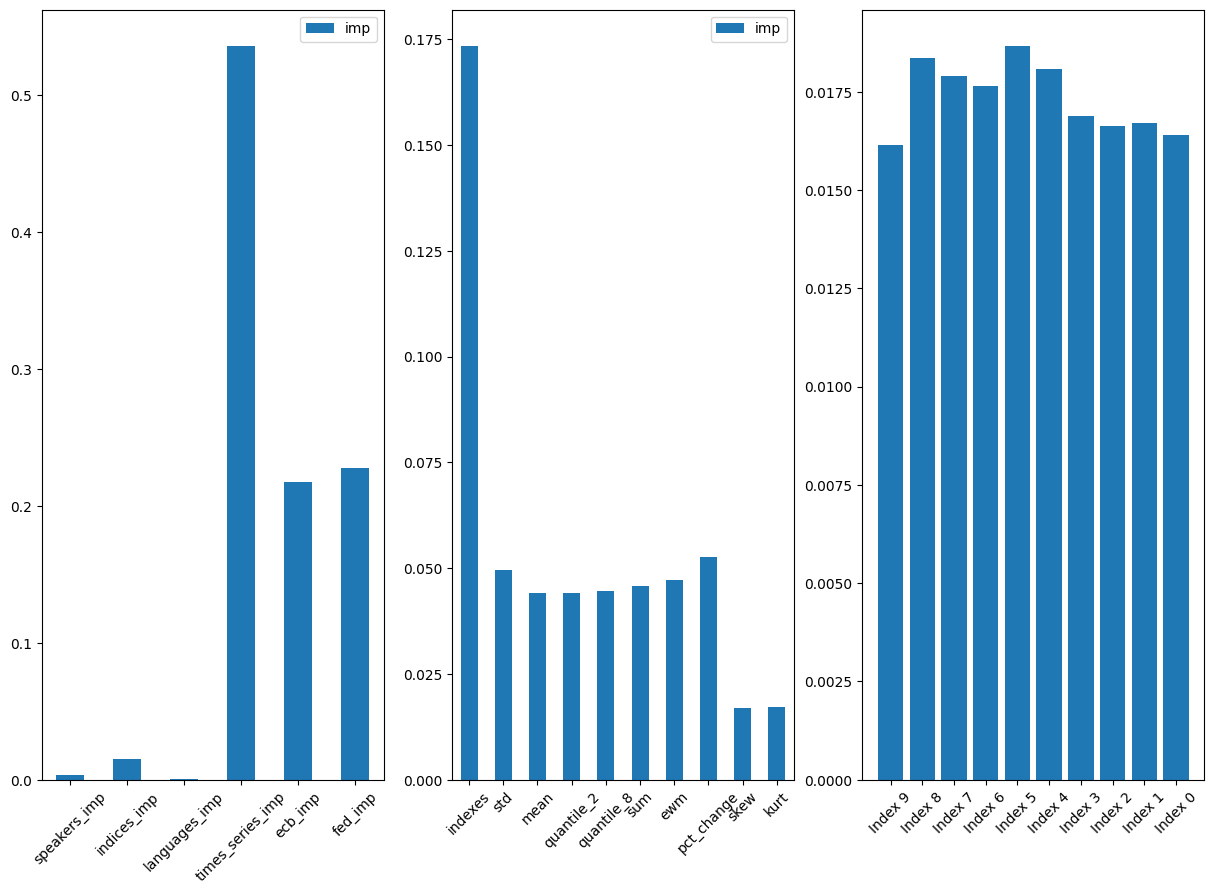

In [221]:
plot_importance_rf(rf2.feature_importances_)

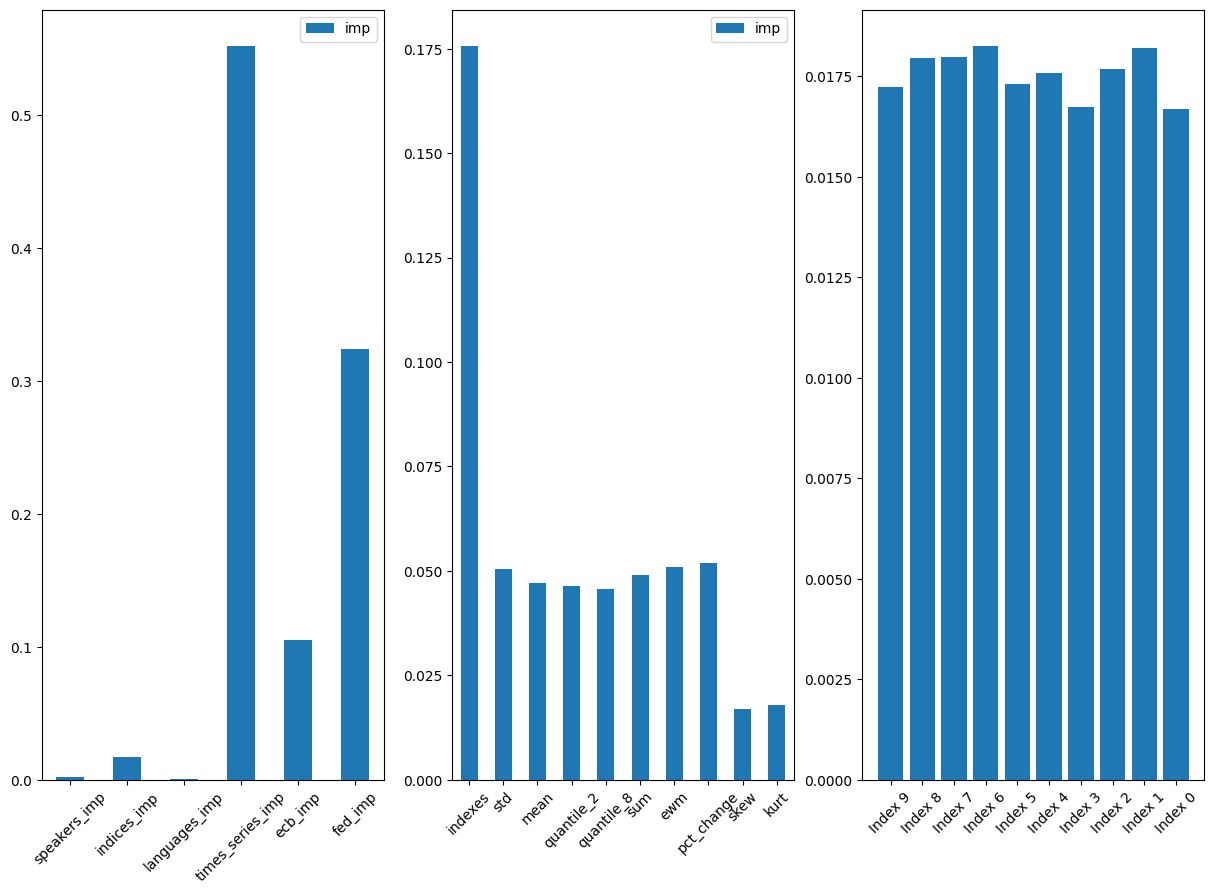

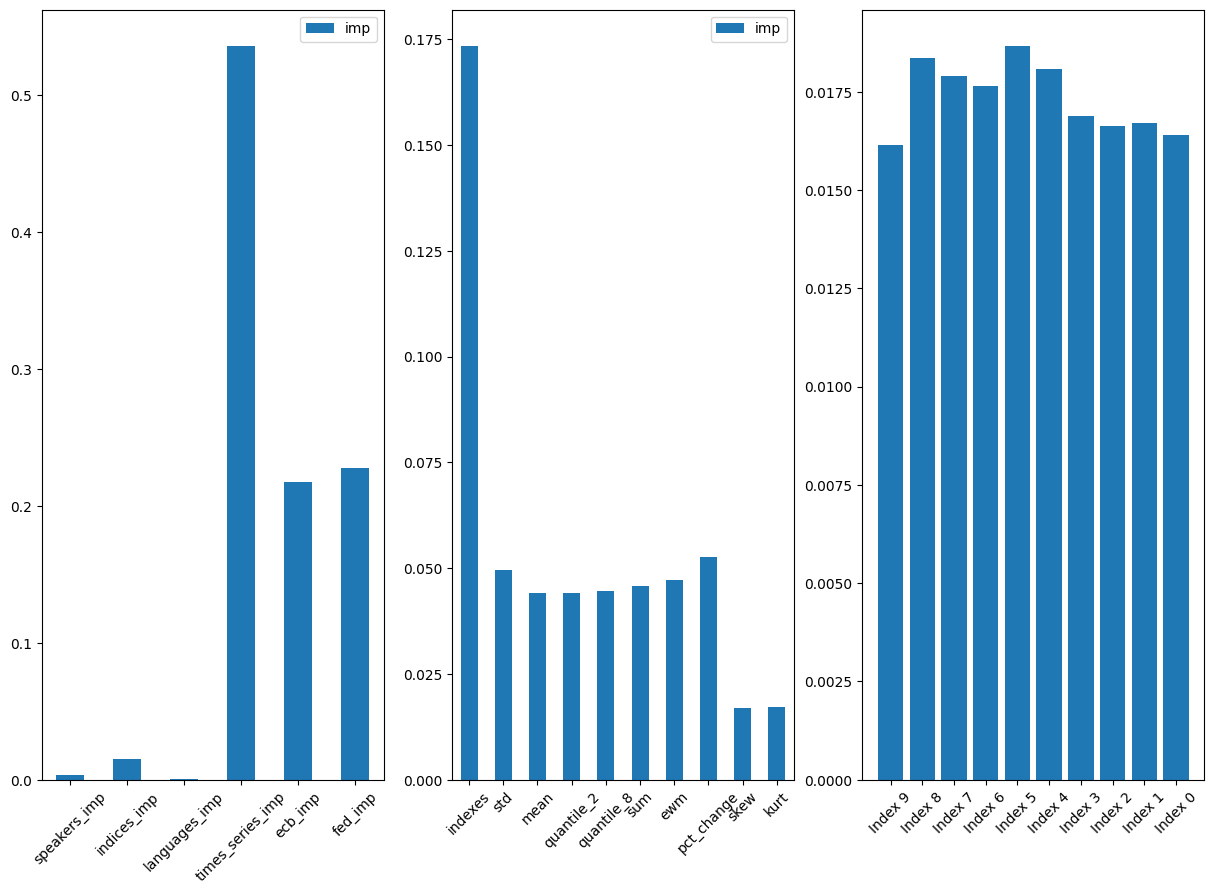

In [222]:
plot_importance_rf(rf.feature_importances_)
plot_importance_rf(rf2.feature_importances_)

3rd Method

Score of the RandomForest_BankFin pipeline: 1.0 (train set)
Score of the RandomForest_BankFin pipeline: 0.570995145631068 (test set)
Overfitting estimated at : 0.429004854368932
              precision    recall  f1-score   support

        -1.0       0.56      0.61      0.59       822
         1.0       0.58      0.53      0.55       826

    accuracy                           0.57      1648
   macro avg       0.57      0.57      0.57      1648
weighted avg       0.57      0.57      0.57      1648



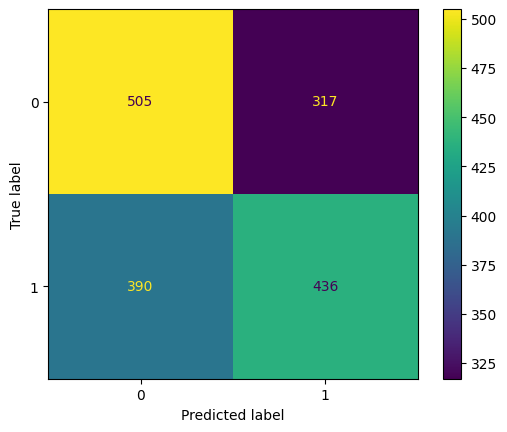

In [176]:
rf3 = RandomForestClassifier()
rf3 = model_eval(
    rf2,
    "RandomForest_BankFin",
    X_train_concat3,
    np.array(y_train).ravel(),
    X_test_concat3,
    np.array(y_test).ravel(),
)

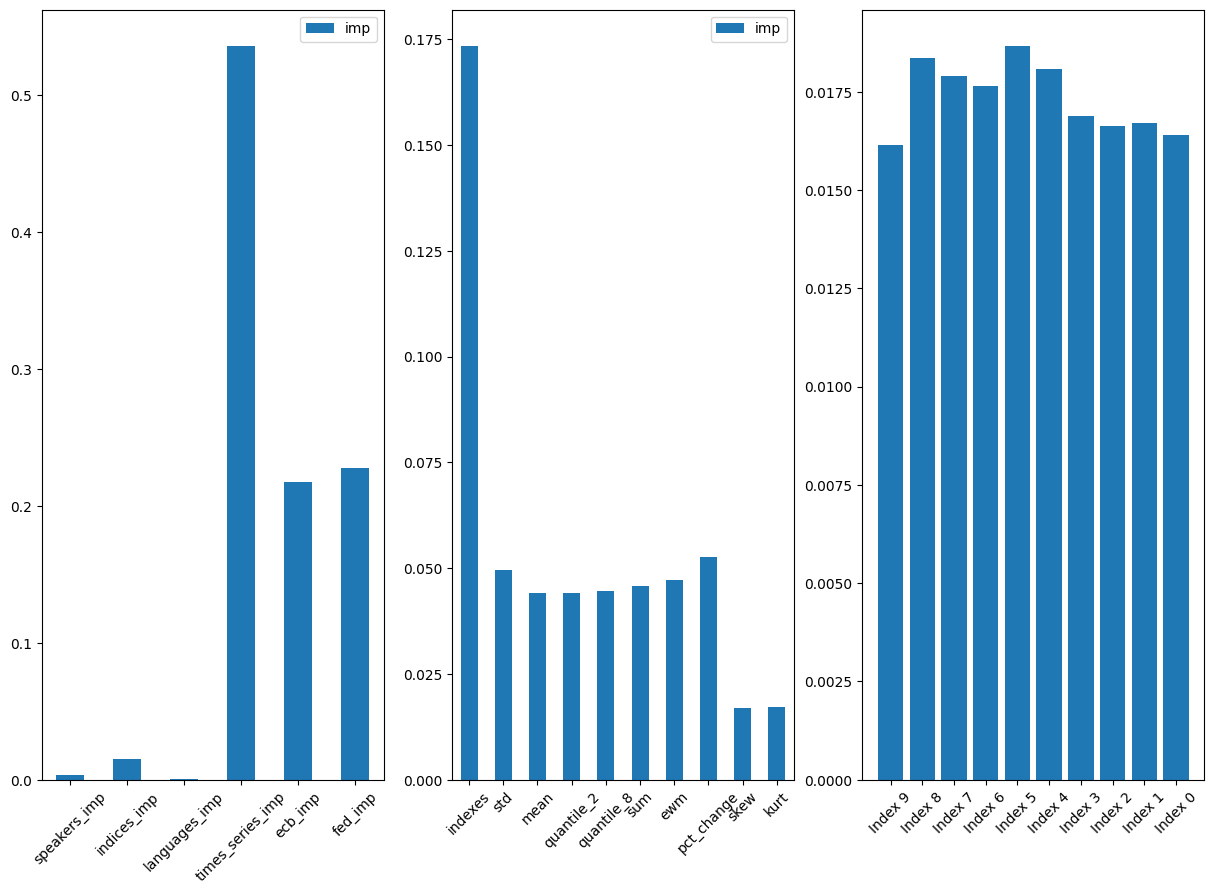

In [223]:
plot_importance_rf(rf3.feature_importances_)

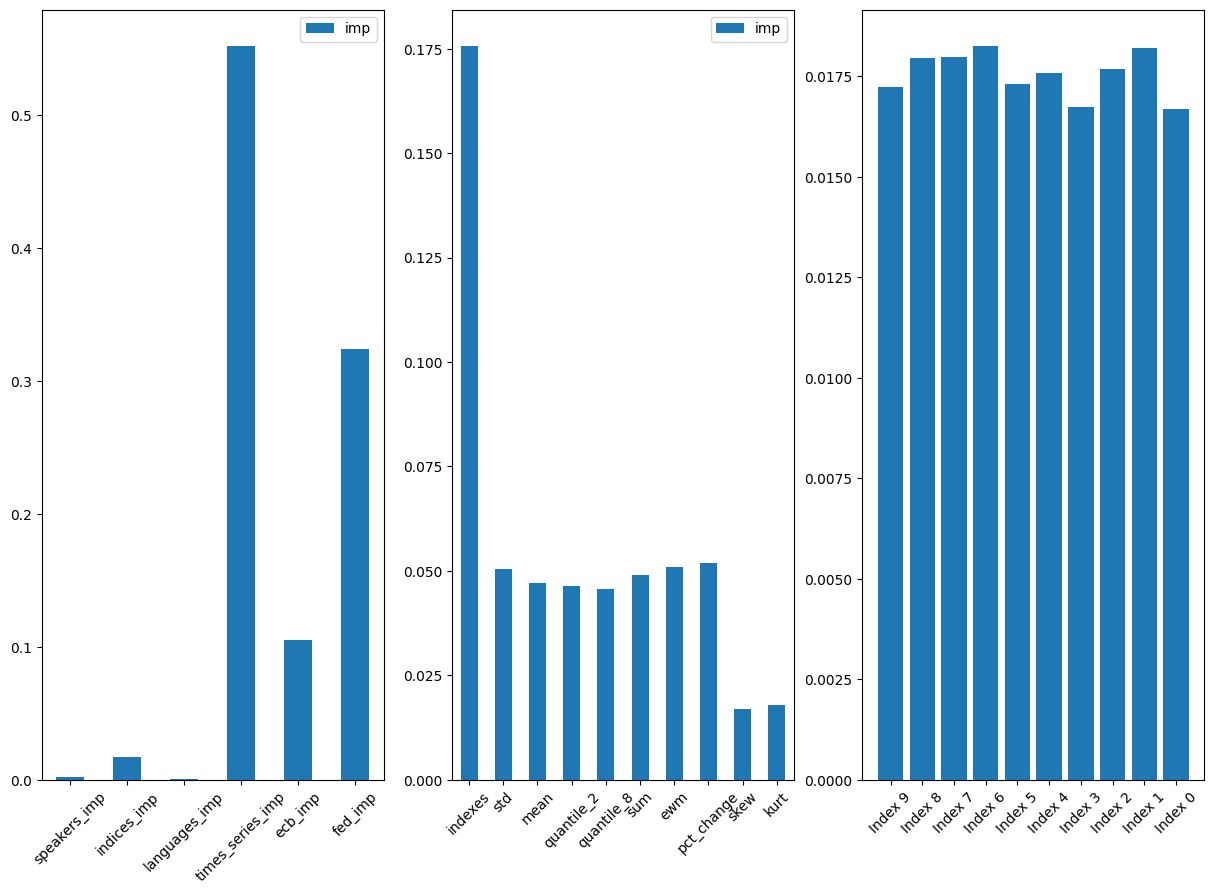

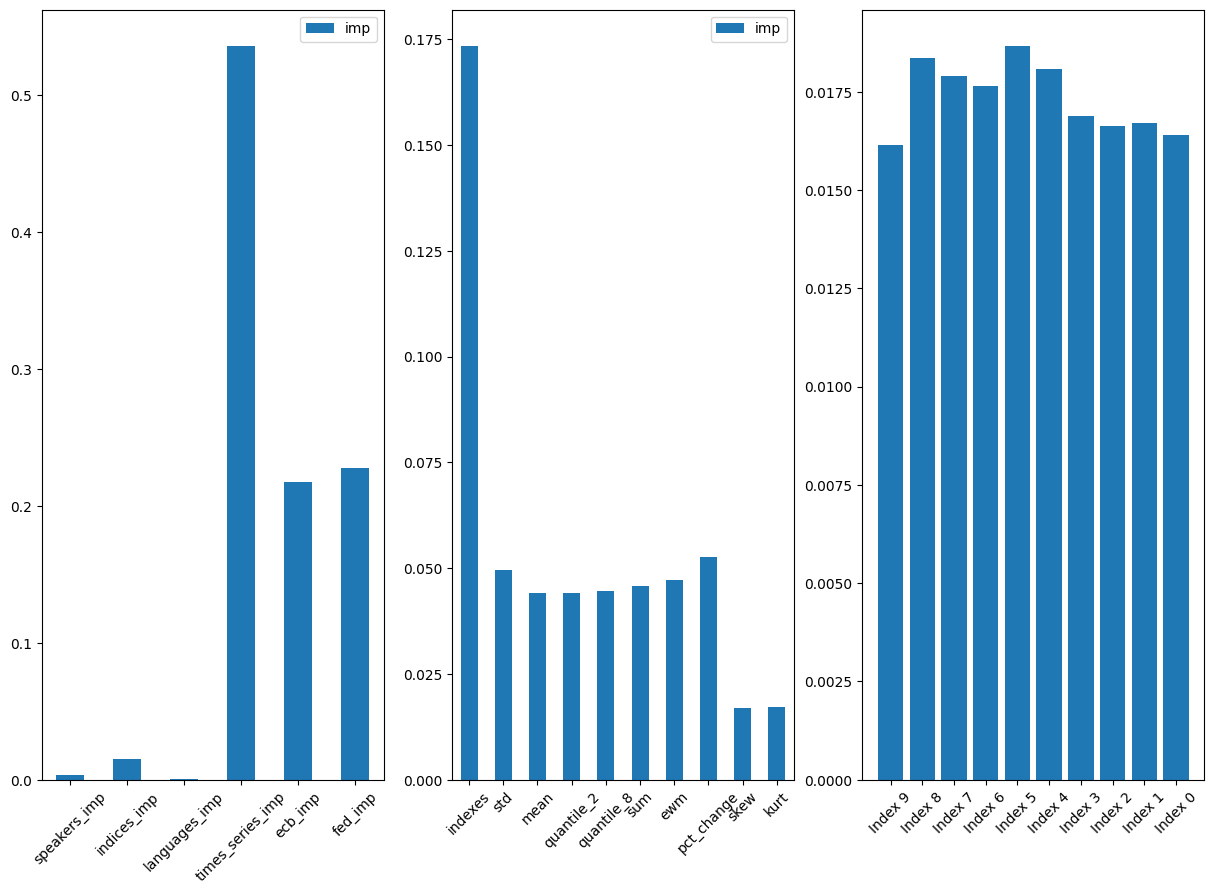

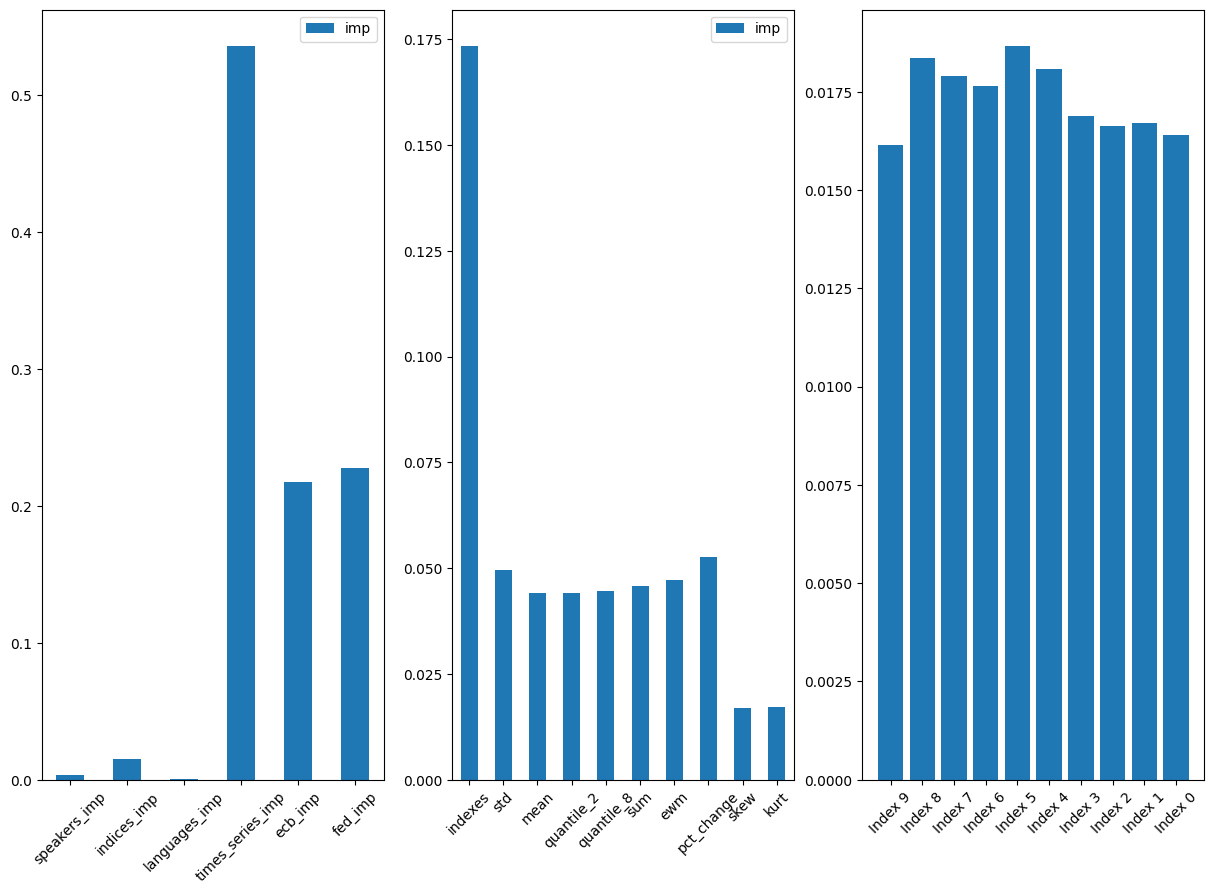

In [224]:
plot_importance_rf(rf.feature_importances_)
plot_importance_rf(rf2.feature_importances_)
plot_importance_rf(rf3.feature_importances_)

## XGBOOST 

In [179]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

model = XGBClassifier()

map_xgboost = {-1.0: 0, 1.0: 1}
y_train_xgboost = y_train["Index + 1"].map(map_xgboost)

# define evaluation procedure
cv = KFold(n_splits=4, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(
    model, X_train_concat3, y_train_xgboost, scoring="accuracy", cv=cv, n_jobs=-1
)


In [198]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

map_xgboost = {-1.0: 0, 1.0: 1}
y_train_xgboost = y_train["Index + 1"].map(map_xgboost)

estimator = XGBClassifier(
    objective= 'binary:logistic',
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': [100],
    'colsample_bytree': [0.8,0.6,0.4],
    #'learning_rate': [0.1, 0.01, 0.05],
}

# define evaluation procedure
cv = KFold(n_splits=4, random_state=42, shuffle=True)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = cv,
    verbose=True
)

In [199]:
grid_search.fit(X_train_concat, y_train_xgboost)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     int...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.6, 0.4],
                         'max_depth': range(2, 10), 'n_estimators': [100]},
             scoring='accuracy', verbose=True)

In [187]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [203]:
pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")["params"].values

array([{'colsample_bytree': 0.8, 'max_depth': 9, 'n_estimators': 100},
       {'colsample_bytree': 0.6, 'max_depth': 8, 'n_estimators': 100},
       {'colsample_bytree': 0.6, 'max_depth': 9, 'n_estimators': 100},
       {'colsample_bytree': 0.8, 'max_depth': 7, 'n_estimators': 100},
       {'colsample_bytree': 0.4, 'max_depth': 9, 'n_estimators': 100},
       {'colsample_bytree': 0.4, 'max_depth': 8, 'n_estimators': 100},
       {'colsample_bytree': 0.8, 'max_depth': 8, 'n_estimators': 100},
       {'colsample_bytree': 0.4, 'max_depth': 7, 'n_estimators': 100},
       {'colsample_bytree': 0.8, 'max_depth': 6, 'n_estimators': 100},
       {'colsample_bytree': 0.6, 'max_depth': 7, 'n_estimators': 100},
       {'colsample_bytree': 0.6, 'max_depth': 5, 'n_estimators': 100},
       {'colsample_bytree': 0.4, 'max_depth': 6, 'n_estimators': 100},
       {'colsample_bytree': 0.4, 'max_depth': 5, 'n_estimators': 100},
       {'colsample_bytree': 0.8, 'max_depth': 5, 'n_estimators': 100},
      

In [96]:
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.55886


In [100]:
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.56311


In [180]:
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.54460


Score of the XGBoost_SVD pipeline: 0.9987864077669902 (train set)
Score of the XGBoost_SVD pipeline: 0.5588592233009708 (test set)
Overfitting estimated at : 0.4399271844660194
              precision    recall  f1-score   support

           0       0.56      0.58      0.57       822
           1       0.56      0.54      0.55       826

    accuracy                           0.56      1648
   macro avg       0.56      0.56      0.56      1648
weighted avg       0.56      0.56      0.56      1648



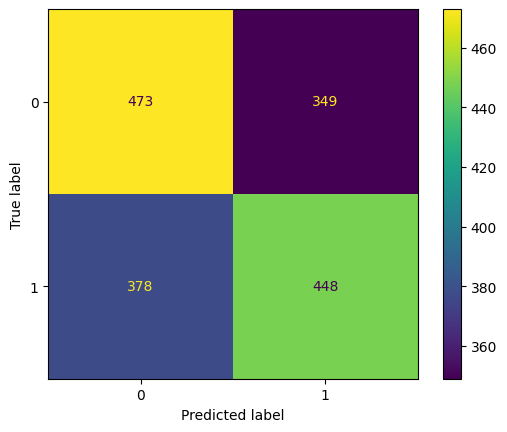

In [182]:
model = XGBClassifier()
map_xgboost = {-1.0: 0, 1.0: 1}
y_train_xgboost = y_train["Index + 1"].map(map_xgboost)
y_test_xgboost = y_test["Index + 1"].map(map_xgboost)

model = model_eval(
    model,
    "XGBoost_SVD",
    X_train_concat,
    y_train_xgboost,
    X_test_concat,
    y_test_xgboost,
)